# Script to scan the PSSS screen position
### Purpose:
The detection plane of the PSSS is imaged by a screen and camera. This script will scan the screen position to find the location of the spectrometer imaging plane

Contact christopher.arrell@psi.ch

In [1]:
import epics as ep
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from collections import deque
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
%matplotlib inline
from IPython.display import clear_output, display

## Setup and functions setup

In [2]:
PSSS_FWHM_name = 'SARFE10-PSSS059:SPECTRUM_FWHM'
PSSS_screen_z_name = 'SARFE10-PSSS059:MOTOR_Z5'
PSSS_e_axis_name = 'SARFE10-PSSS059:SPECTRUM_X'
PSSS_spectrum_name = 'SARFE10-PSSS059:SPECTRUM_Y'

PSSS_FWHM_PV = ep.PV(PSSS_FWHM_name)
PSSS_screen_z_PV = ep.PV(PSSS_screen_z_name)
PSSS_spectrum_PV = ep.PV(PSSS_spectrum_name)
PSSS_e_axis_PV = ep.PV(PSSS_e_axis_name)

def set_screen_z(pos):
    PSSS_screen_z_PV.put(pos, wait=True)

def PSSS_screen_z_scan(Range, NumShots):
        
    screen_scan = []
            
    for pos in Range:
        set_screen_z(pos)
        sleep(2)
           
        Spectrum_this_energy = deque(maxlen = NumShots)
        def on_value_change(value=None,pv = None, **kwargs):
            Spectrum_this_energy.append(value)

            if len(Spectrum_this_energy) == NumShots:
                pv.clear_callbacks()
                
        PSSS_FWHM_PV.add_callback(callback=on_value_change, pv =PSSS_FWHM_PV)
        while len(Spectrum_this_energy) < NumShots:
            sleep(1)
        screen_scan.append(np.array(Spectrum_this_energy))
        
    return(np.array(screen_scan))

def gaus(x,a,x0,sigma,offset):
    return offset +a*np.exp(-(x-x0)**2/(2*sigma**2))

## User inputs - define travel range of crystal
It is unlikely these values need to be changed

In [3]:
screen_z_from = -0.1
screen_z_to = 0.1
steps = 10
NumShots= 250
screen_z_range = np.linspace(screen_z_from, screen_z_to, steps)

## Scan and take data

In [4]:
Scan_spec = PSSS_screen_z_scan(screen_z_range,NumShots)

## Plot and return maxium position


In [ ]:
course_scan = Scan_spec.mean(axis=1)

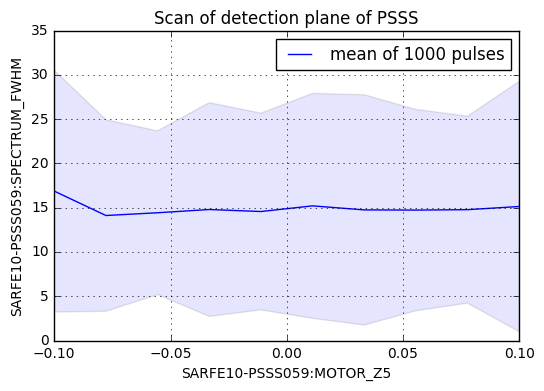

In [6]:
plt.figure()
plt.title('Scan of detection plane of PSSS')
plt.plot(screen_z_range, Scan_spec.mean(axis=1), label = 'mean of 1000 pulses')
plt.fill_between(screen_z_range,Scan_spec.mean(axis=1)-Scan_spec.std(axis=1),Scan_spec.mean(axis=1)+Scan_spec.std(axis=1), alpha = 0.1)
plt.legend()
plt.xlim([-0.1,0.1])
plt.ylabel(PSSS_FWHM_name)
plt.xlabel(PSSS_screen_z_name)
plt.grid(True)

In [5]:
projection = Scan_spec.mean(axis=1).mean(axis=1)
signal_centre = xstal_range[np.argmax(projection)]
xstal_range_fit = np.linspace(xstal_range[0], xstal_range[-1], len(xstal_range)*10)
energy_axis = PSSS_e_axis_PV.get()
try:
    popt,pcov = curve_fit(gaus,xstal_range,projection,p0=[100,signal_centre,-0.2,100])
except:
    print('Fit failed: spectrum might not be near scan range center')
    popt = [0.0, 0.0, 0.0, 0.0]
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('PSSS scan of crystal height')
plt.pcolormesh(energy_axis, xstal_range, Scan_spec.mean(axis=1),cmap='CMRmap')
plt.xlim([energy_axis[0],energy_axis[-1]])
plt.ylim([xstal_range[0], xstal_range[-1]])
plt.xlabel('PSSS energy axis')
plt.ylabel('Set crystal position [mm] \n'+PSSS_xstal_height_name[0:-4])
plt.subplot(122)
plt.plot(projection,xstal_range,linewidth = 2, color = 'orange',label ='projected signal')
plt.plot(gaus(xstal_range_fit,*popt),xstal_range_fit,'r:',label='fit')
plt.ylim([xstal_range[0], xstal_range[-1]])
plt.title('Signal max at %.3f [mm] (from fit)'%popt[1])
plt.xticks([])
plt.legend()
plt.grid(True)

IndexError: tuple index out of range

## Set max position
Cell below will push the maximum position to the xstal height

In [ ]:
set_xstal_height(popt[1])